### Key Pointers and what to do

Run a lasso regression analysis using k-fold cross validation.
Identify a subset of predictors from a larger pool of predictor variables that best predicts a quantitative response variable.

### Dataset used and Descriptions

Bike Sharing Demand 

Download link [Kaggle](https://www.kaggle.com/c/bike-sharing-demand/data)

### Data Fields

* yr - Year
* mnth - Month
* holiday - Holiday
* weekday - Week Day
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed(mph) - wind speed , miles per hour
* windspeed(ms) - wind speed , meter per seconds

Target:
* cnt - number of total rentals

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLarsCV
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import seaborn as sns
%matplotlib inline 

rnd_state = 178

In [8]:
bike_data = pd.read_csv("data/bikes_rent.csv")
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          731 non-null    int64  
 1   yr              731 non-null    int64  
 2   mnth            731 non-null    int64  
 3   holiday         731 non-null    int64  
 4   weekday         731 non-null    int64  
 5   workingday      731 non-null    int64  
 6   weathersit      731 non-null    int64  
 7   temp            731 non-null    float64
 8   atemp           731 non-null    float64
 9   hum             731 non-null    float64
 10  windspeed(mph)  731 non-null    float64
 11  windspeed(ms)   731 non-null    float64
 12  cnt             731 non-null    int64  
dtypes: float64(5), int64(8)
memory usage: 74.4 KB


In [12]:
# Get Stats of the Bike Data
bike_data.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,20.310776,23.717699,62.789406,12.762576,5.705220,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,7.505091,8.148059,14.242910,5.192357,2.321125,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,0.670650,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.820424,16.892125,52.000000,9.041650,4.041864,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,20.431653,24.336650,62.666700,12.125325,5.420351,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.872077,30.430100,73.020850,15.625371,6.984967,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,15.198937,8714.000000


In [11]:
# Get 5 Records
bike_data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


In [15]:
# Get the Null value count in all dataset
bike_data.isna().sum().sum()

0

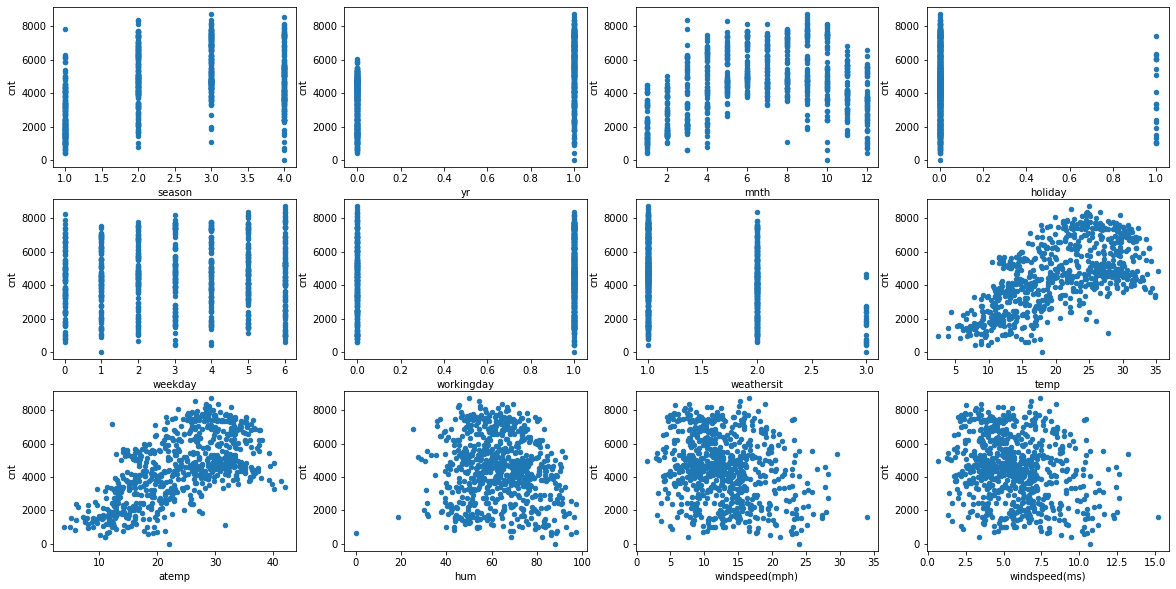

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
for idx, feature in enumerate(bike_data.columns.values[:-1]):
    bike_data.plot(feature, 'cnt', subplots=True, kind='scatter', ax=axes[int(idx / 4), idx % 4]);

In [20]:
bike_data.iloc[:, :12].corrwith(bike_data['cnt'])

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

Above Coorelation Plot shows that there is linear dependences between:-
1. temp vs cnt (0.62)
2. atemp vs cnt (0.63)

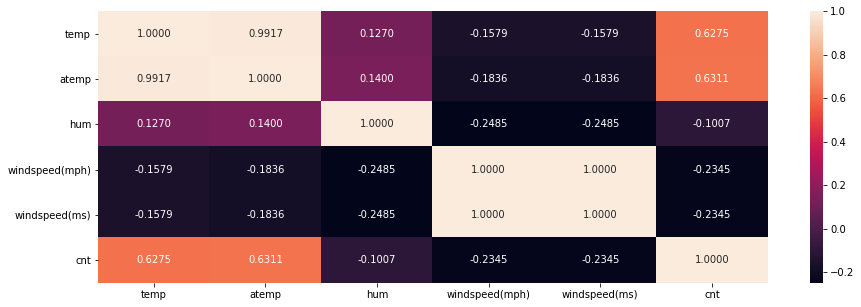

In [21]:
plt.figure(figsize=(15, 5))
sns.heatmap(bike_data[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr(), annot=True, fmt='1.4f');

Strong correlation between temp and atemp and  windspeed(mph) and windspeed(ms) features.
In model building two of those features will be dropped or applyed with penalty (L2 or Lasso regression).

In [23]:
# Getting Independent and Independent Value
pred = bike_data.iloc[:, :12]
tar = bike_data['cnt']

In [24]:
# Split the Dataset into 70:30 ratio
(pred_train, pred_test,
 tar_train, tar_test) = train_test_split(pred, tar, test_size = .3, random_state = rnd_state)

In [25]:
model = LassoLarsCV(cv=10, precompute=False).fit(pred_train, tar_train)

In [26]:
dict(zip(pred.columns, model.coef_))

{'season': 494.1697958210351,
 'yr': 2031.398409833861,
 'mnth': -40.05929880547262,
 'holiday': -568.9316554062252,
 'weekday': 69.35323372222,
 'workingday': 123.84108766957,
 'weathersit': -589.4448624391796,
 'temp': 60.459425243675206,
 'atemp': 60.770144273610974,
 'hum': -9.812472266085674,
 'windspeed(mph)': 0.0,
 'windspeed(ms)': -89.53537496912934}

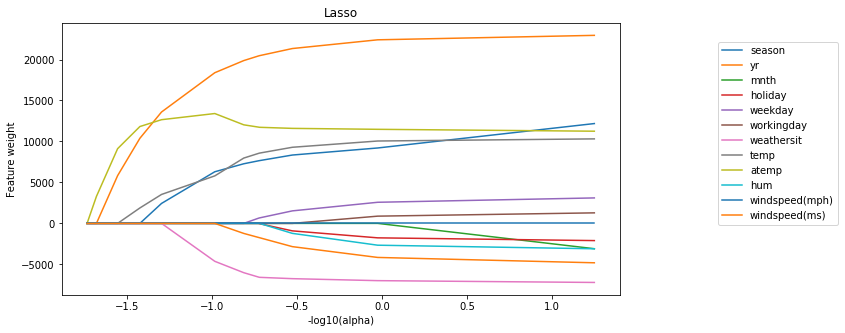

In [30]:
# Plot the Independed Variable to in or out in Model Building proces
log_alphas = -np.log10(model.alphas_)
plt.figure(figsize=(10, 5))
for idx, feature in enumerate(pred.columns):
    plt.plot(log_alphas, list(map(lambda r: r[idx], model.coef_path_.T)), label=feature)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("-log10(alpha)")
plt.ylabel("Feature weight")
plt.title("Lasso");

In [29]:
# Getting the R-Squared
rsq_train = model.score(pred_train, tar_train)
rsq_test = model.score(pred_test, tar_test)
print('Training data R-square', rsq_train)
print('Test data R-square', rsq_test)

Training data R-square 0.7879656416052324
Test data R-square 0.8273386678281877


### Insights

Lasso Algo is used to predict bike count from the 12 independent variables.
Also get the non-zero regression coefficients variables are most strongly associated with the response variable.

With k=10 fold cross validation to build model and is validated on test set.

Out of the 12 predictor variables, 10 variables are strongly associated with the response variable:

* 'season': 494.1697958210351,
* 'yr': 2031.398409833861,
* 'mnth': -40.05929880547262,
* 'holiday': -568.9316554062252,
* 'weekday': 69.35323372222,
* 'workingday': 123.84108766957,
* 'weathersit': -589.4448624391796,
* 'temp': 60.459425243675206,
* 'atemp': 60.770144273610974,
* 'hum': -9.812472266085674,
* 'windspeed(mph)': 0.0,
* 'windspeed(ms)': -89.53537496912934

Train dataset R-square= 0.79
Test dataset R-square= 0.83